In [10]:
# Zachary Katz
# zachary_katz@mines.edu
# 02 August 2024

# Plot Figure S2 for Whillans Catalog Paper
# Tide comparison for GZ05

# Imports
import os
import sys

sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Catalog",
)
sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Tides",
)
import Catalog
import Tides
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import scipy
from astropy.timeseries import LombScargle
import datetime

dir = "/mnt/d/csrs_2024/all"
stas = ["gz05"]
# year_arr = [["2007"],["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]
year_arr = [["2011"]]
# Detection parameters
max_gap_len = 120  # Maximum gap length to interpolate [seconds]

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.
loglevel = "INFO"


def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [2]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

2024-10-23 20:45:02 __main__ INFO: Creating Dataframe for gz05
2024-10-23 20:45:25 __main__ INFO: Interpolating gz05


In [3]:
# Set where to calculate tides
lats = [-84.2986]
lons = [-164.5206]

# Set model location
model_loc = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
model = "CATS2008-v2023"

tide_mod = Tides.Tide(model_loc=model_loc, model=model)

# Model tides at same times
tide_times = cats[0].data["time"]
modeled_tides = tide_mod.tidal_elevation(lons, lats, tide_times)

[[-52.70285614592828]
 [-52.86492775014686]
 [-52.86492775014686]
 [-52.86492775014686]
 [-52.86492775014686]
 [-53.02526035856017]
 [-53.02526035856017]
 [-53.02526035856017]
 [-53.02526035856017]
 [-53.18384331146602]
 [-53.18384331146602]
 [-53.18384331146602]
 [-53.18384331146602]
 [-53.34066603536276]
 [-53.34066603536276]
 [-53.34066603536276]
 [-53.34066603536276]
 [-53.49571804026431]
 [-53.49571804026431]
 [-53.49571804026431]
 [-53.49571804026431]
 [-53.64898892225914]
 [-53.64898892225914]
 [-53.64898892225914]
 [-53.64898892225914]
 [-53.80046836445573]
 [-53.80046836445573]
 [-53.80046836445573]
 [-53.80046836445573]
 [-53.9501461354042]
 [-53.9501461354042]
 [-53.9501461354042]
 [-53.9501461354042]
 [-54.09801209278615]
 [-54.09801209278615]
 [-54.09801209278615]
 [-54.09801209278615]
 [-54.24405618194038]
 [-54.24405618194038]
 [-54.24405618194038]
 [-54.24405618194038]
 [-54.38826853434611]
 [-54.38826853434611]
 [-54.38826853434611]
 [-54.38826853434611]
 [-54.53063908

In [8]:
# Find difference
data = (cats[0].data["elevation"] - np.mean(cats[0].data["elevation"])) * 100
diff = [data[i] - modeled_tides.data[i] for i in range(len(data))]

In [36]:
# Lomb scargle periodogram of the difference
segment_st = 0
segment_ed = 1000000

dates_as_sec = [a.timestamp() for a in tide_times[segment_st:segment_ed]]
tot_slips_masked = np.ma.masked_array(
    diff[segment_st:segment_ed], mask=np.invert(~np.isnan(diff[segment_st:segment_ed]))
)
dates_as_sec_masked = np.ma.masked_array(
    dates_as_sec, mask=np.invert(~np.isnan(diff[segment_st:segment_ed]))
)
tot_slips_masked = np.ma.compressed(tot_slips_masked)
dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

# Spectrogram of rolling avg slips using lomb scargle
frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
period = 1 / frequency / SEC_TO_HR  # Days

Text(-0.08, 0.95, 'b.')

/home/zkatz/miniconda3/envs/gps/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


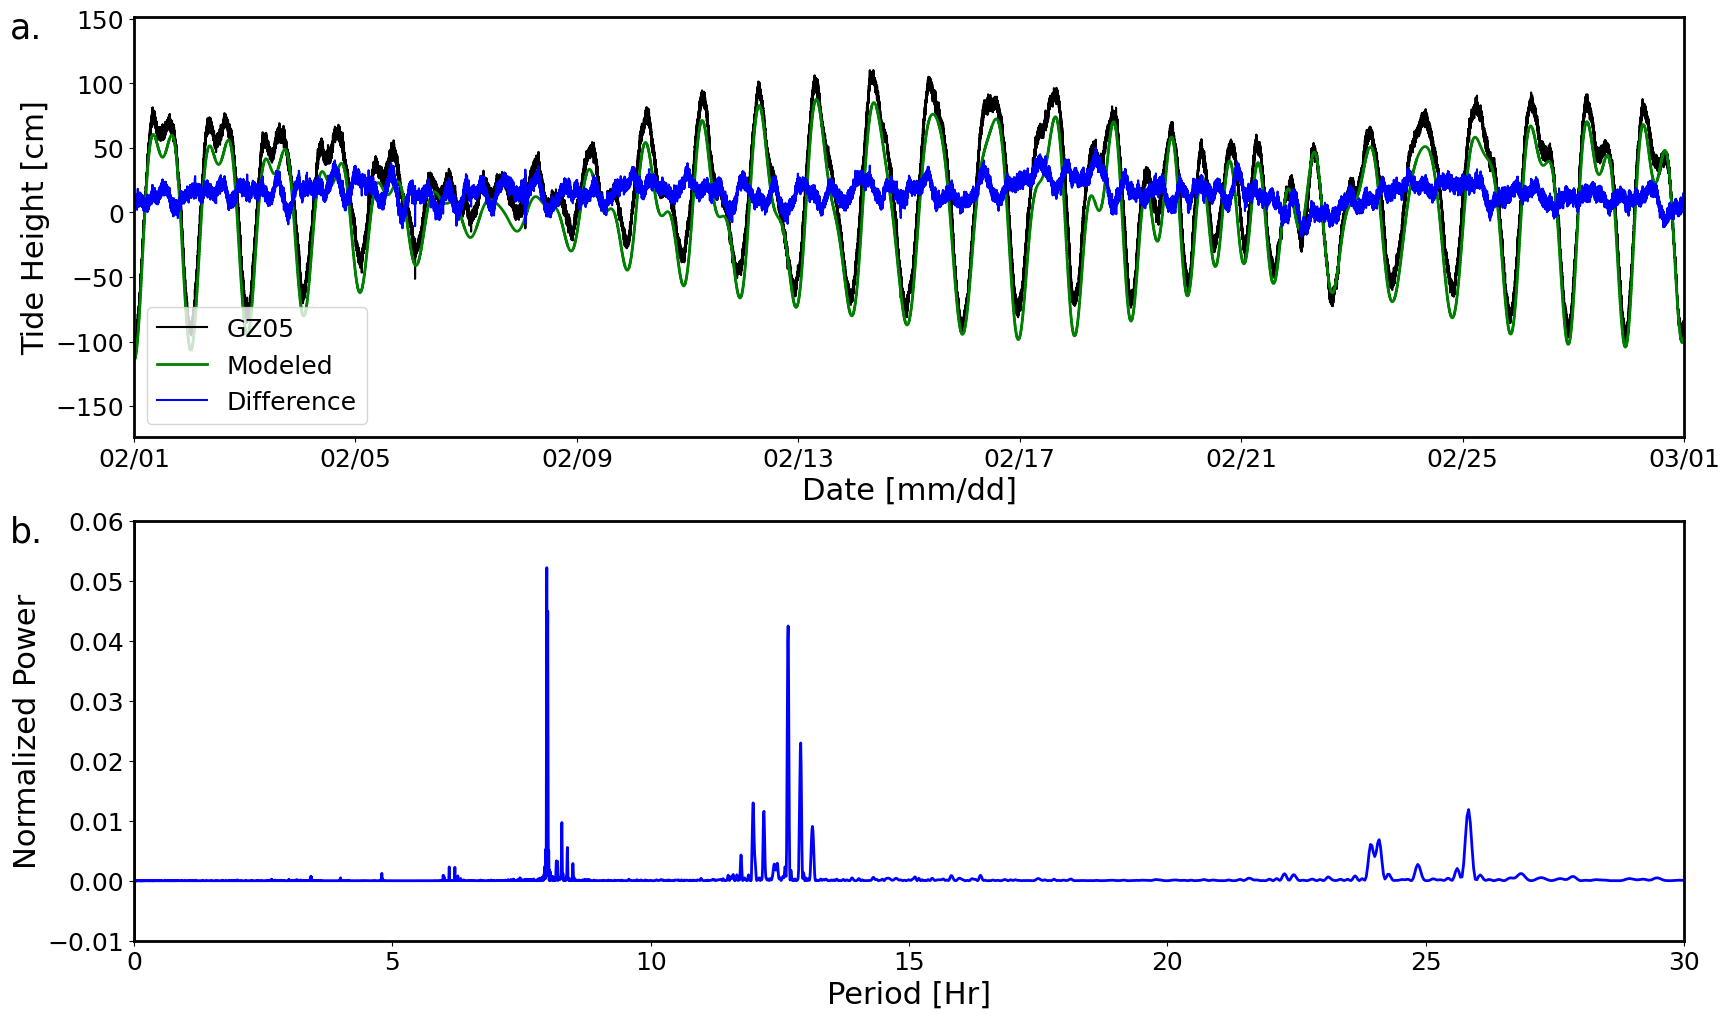

In [46]:
# Plot figure S2
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 12))

ax1.plot(tide_times, data, label="GZ05", color="black")
ax1.plot(tide_times, modeled_tides.data, label="Modeled", color="green", linewidth=2)
ax1.plot(tide_times, diff, label="Difference", color="blue")
ax1.legend(fontsize=18)

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

ax1.set_xlabel("Date [mm/dd]", size=22)
ax1.set_ylabel("Tide Height [cm]", size=22)

ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_xlim(datetime.datetime(2011, 2, 1), datetime.datetime(2011, 3, 1))


ax2.plot(period, power, color="blue", linewidth=2)

ax2.set_xlabel("Period [Hr]", fontsize=22)
ax2.set_ylabel("Normalized Power", fontsize=22)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_xlim(0, 30)
ax2.set_ylim(-0.01, 0.06)

ax1.annotate("a.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)
ax2.annotate("b.", (-0.08, 0.95), xycoords="axes fraction", fontsize=25)

In [ ]:
# Plot tides
fig, ax = plt.subplots()
data = (cats[0].data["elevation"] - np.mean(cats[0].data["elevation"])) * 100
ax.plot(cats[0].data["time"], data, label="Data", color="green")
ax.plot(tide_times, modeled_tides, label="Model", color="black")
ax.set_xlabel("Time")
ax.set_ylabel("Tide Height [cm]")
# ax.legend()
ax.set_xlim([tide_times[0], tide_times[50000]])

(0.0, 50.0)

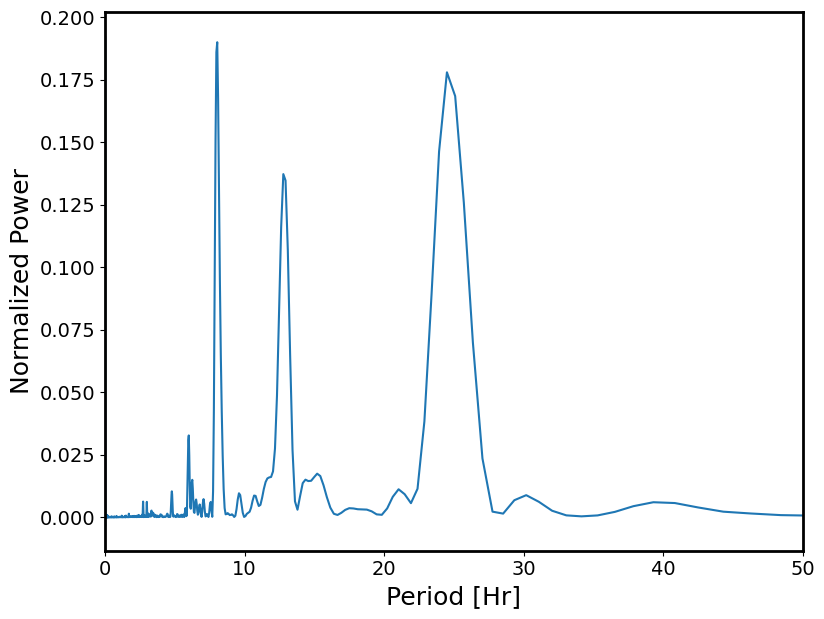

In [14]:
SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
fig, ax = plt.subplots(figsize=(9, 7))
# ax.plot(frequency[pks], power[pks], 'ro')
period = 1 / frequency / SEC_TO_HR  # Days
ax.plot(period, power)

ax.set_xlabel("Period [Hr]", fontsize=18)
ax.set_ylabel("Normalized Power", fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlim(0, 50)